In [50]:
import nibabel as nib 
! pip install nibabel --user
import os
import glob
import numpy as np
from nibabel.testing import data_path
import matplotlib.pyplot as plt
#import cv2
#! pip install cv2 --user
import time
from datetime import datetime
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.ndimage import zoom
import pandas as pd
import os
from skimage.io import imread
from skimage.color import gray2rgb
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torchvision as tv
from torch.utils.data import (
    Dataset,
    DataLoader,
)
import matplotlib.pyplot as plt
from torch.utils import data as DT
from skimage.transform import radon , iradon
%matplotlib inline
!pip install livelossplot --quiet
from livelossplot import PlotLosses
from sklearn.metrics import r2_score , mean_squared_error

In [51]:
def pad(img_,size_):
    dif=size_-img_.shape[0]
    if dif%2==0:
        img_=np.pad(img_,((dif//2,dif//2),(0,0),(0,0)),'edge')
    else:
        img_=np.pad(img_,(((dif-1)//2,(dif+1)//2),(0,0),(0,0)),'edge')
    dif=size_-img_.shape[1]
    if dif%2==0:
        img_=np.pad(img_,((0,0),(dif//2,dif//2),(0,0)),'edge')
    else:
        img_=np.pad(img_,((0,0),((dif-1)//2,(dif+1)//2),(0,0)),'edge')
    dif=size_-img_.shape[2]
    if dif%2==0:
        img_=np.pad(img_,((0,0),(0,0),(dif//2,dif//2)),'edge')
    else:
        img_=np.pad(img_,((0,0),(0,0),((dif-1)//2,(dif+1)//2)),'edge')
    return img_

In [52]:
path = 'D:\\Master_courses\\Praktikum\\challenge\\hecktor\\data\\resampled\\'

files = [f for f in glob.glob(path + "**/*_ct_gtvt.nii.gz", recursive=True)]
labels_lenght=list()
image_list=list()
label_list=list()

for idx,f in enumerate(files):
    SEG_img = nib.load(f)
    SEG_data = SEG_img.get_fdata()
    if SEG_data.shape!=(64,64,64):
        SEG_data=pad(SEG_data,64)
    label_list.append(SEG_data)
    path=f[:-15]+'_pt.nii.gz'
    im=nib.load(path)
    PET_data=im.get_fdata()
    if PET_data.shape!=(64,64,64):
        PET_data=pad(PET_data,64)
    image_list.append(PET_data)
    #print(idx)


In [53]:
len(image_list) # number of patients

200

In [54]:
print (image_list[0].shape)

(64, 64, 64)


In [55]:
size = 16 # patch size
stride = 16 # patch stride

all_labels=list()
for seg_img in label_list:
    positive_cells_number=np.sum(seg_img)
    #print("positive_cells_number",positive_cells_number)
    patches = torch.from_numpy(seg_img).unfold(0, size, stride).unfold(1, size, stride).unfold(2, size, stride)
    reshaped_patches=patches.reshape(-1,size,size,size)
    labels_=(torch.sum(reshaped_patches , dim=(1,2,3)).int().numpy())/positive_cells_number
    #print ("labels_", labels_)
    all_labels.append(labels_)
all_labels=np.asarray(all_labels).reshape(-1)

In [56]:
all_labels[:64] # labels of one patient

array([ 0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,
        0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,
        0.000,  0.000,  0.000,  0.000,  0.000,  0.002,  0.008,  0.000,
        0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,
        0.000,  0.000,  0.001,  0.000,  0.000,  0.112,  0.691,  0.035,
        0.000,  0.017,  0.105,  0.001,  0.000,  0.000,  0.000,  0.000,
        0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.026,  0.000,
        0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000,  0.000])

In [57]:
all_PET_patches=list()
for PET_img in image_list:
    patches = torch.from_numpy(PET_img).unfold(0, size, stride).unfold(1, size, stride).unfold(2, size, stride)
    reshaped_patches=patches.reshape(-1,size,size,size).numpy()
    all_PET_patches.append(reshaped_patches)
all_PET_patches=np.asarray(all_PET_patches).reshape(-1,size,size,size)

In [58]:
print (all_PET_patches.shape) #number of patches * pactch dim1 * patch dim2 * patch dim3
patch_mean=np.mean(all_PET_patches , axis=0)
patch_std=np.std(all_PET_patches , axis=0)

(12800, 16, 16, 16)


In [59]:
class HN_Dataset(Dataset):
    def __init__(self, transform=tv.transforms.Compose(tv.transforms.ToTensor())):
        self.labels = all_labels
        self.images=all_PET_patches
        self.transform = transform
        self.mode='None'
    def __len__(self):
        return len(all_labels)

    def __getitem__(self, idx):

        label= torch.from_numpy(np.asarray(self.labels[idx]))
        
        if self.transform is not None:
            PET_data = self.transform(self.images[idx])
        return (PET_data, label)

In [60]:
split_threshold=10000  # to split test and train set
batch_size = 64

# Load Data

idx = list(range(len(all_labels)))

dataset = HN_Dataset( transform=tv.transforms.ToTensor())
#train_set = DT.Subset(dataset, idx[:split_threshold])
#test_set = DT.Subset(dataset, idx[split_threshold:])

train_set, test_set = torch.utils.data.random_split(dataset, [10000, 2800])

train_set.transform= tv.transforms.Compose([#tv.transforms.RandomHorizontalFlip(),
                                            #tv.transforms.RandomVerticalFlip(),
                                            tv.transforms.ToTensor()
                                            #tv.transforms.Normalize(patch_mean, patch_std)
                                           ])

#tv.transforms.RandomRotation(180),

#train_loader = DataLoader(train_set, batch_size=batch_size, sampler= sampler)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


In [61]:

dataIter = iter(train_loader)
imgs, labels = dataIter.next()


print ("labels", labels)


labels tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0734, 0.0000, 0.0000,
        0.0000, 0.0000, 0.2146, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3756,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.2344, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0269, 0.0000, 0.2462, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], dtype=torch.float64)


In [62]:

def save_checkpoint(state, filename="my_checkpoint_3D_V2.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [63]:
class CNN_conv2d(nn.Module):
    def __init__(self, in_channels=16, num_classes=1):
        super(CNN_conv2d, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(5,5),
            stride=(1, 1),
            padding=(2, 2),
        )
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=16,
            kernel_size=(3 ,3),
            stride=(1, 1),
            #padding=(1, 1),
        )
        self.conv3 = nn.Conv2d(
            in_channels=16,
            out_channels=8,
            kernel_size=(3 ,3),
            stride=(1, 1),
            #padding=(1, 1),
        )

        
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        self.fc1 = nn.Linear(16 * 3 * 3, num_classes)
        self.fc2 = nn.Linear(8, num_classes)
        
        self.sig=nn.Sigmoid()
        
        self.BatchNorm64=nn.BatchNorm2d(64)
        self.BatchNorm32=nn.BatchNorm2d(32)
        self.BatchNorm8=nn.BatchNorm2d(8)
        self.BatchNorm128=nn.BatchNorm2d(128)
        self.BatchNorm16=nn.BatchNorm2d(16)
        self.layernorm1=nn.LayerNorm((64, 16, 16))
        self.layernorm2=nn.LayerNorm((32, 8, 8))
        self.layernorm3=nn.LayerNorm((16, 4, 4))
        
        self.initialize_weights()

        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        #x= self.layernorm1(x)
        x = self.BatchNorm32(x)
        x = self.pool(x)
        x = F.leaky_relu(self.conv2(x))
        x = self.BatchNorm16(x)
        #x= self.layernorm2(x)
        x = self.pool(x)
        #x = F.leaky_relu(self.conv3(x))
        #x = self.BatchNorm8(x)
        #x= self.layernorm3(x)
        #x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        #x = self.fc2(x)
        x=self.sig(x)
        return x

    

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)


In [65]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
#in_channel = 32
#num_classes = 2
num_epochs = 50
learning_rate = 1e-3
batch_size = 64

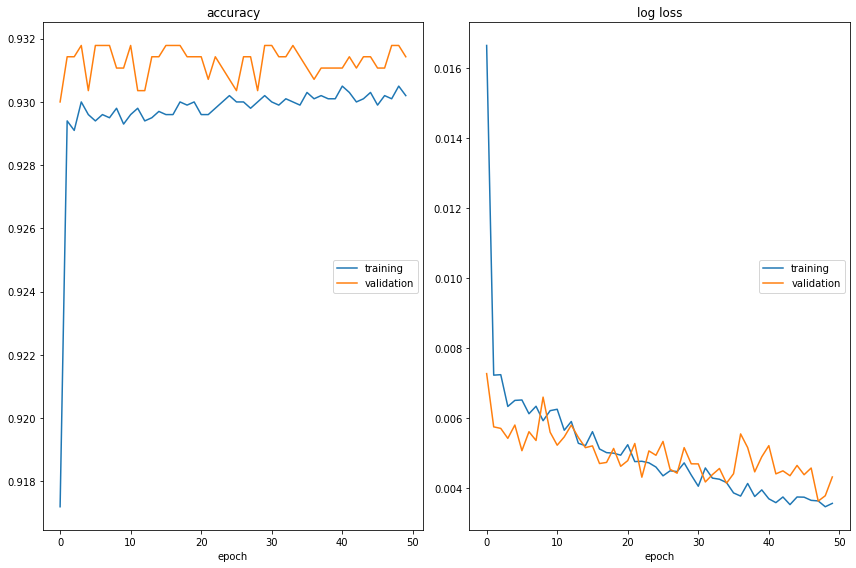

accuracy
	training         	 (min:    0.917, max:    0.930, cur:    0.930)
	validation       	 (min:    0.930, max:    0.932, cur:    0.931)
log loss
	training         	 (min:    0.003, max:    0.017, cur:    0.004)
	validation       	 (min:    0.004, max:    0.007, cur:    0.004)


In [66]:
#device=torch.device("cpu")
# Initialize network
model = CNN_conv2d().to(device)
#model = model.float()
liveloss = PlotLosses()
# Loss and optimizer
#criterion = nn.BCELoss()
#criterion=nn.BCEWithLogitsLoss()
criterion=nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
load_module=False

dataloaders = {
    "train": train_loader,
    "validation": test_loader
}

# Train Network
for epoch in range(num_epochs):
    logs = {}
    for phase in ['train', 'validation']:

        if phase == 'train':
            model.train()
        else:
            model.eval()

            
        running_loss = 0.0
        running_corrects = 0.0
        #now = datetime.now()

        #losses = []
        for inputs, labels in dataloaders[phase]:
            # Get data to cuda if possible
            inputs = inputs.to(device=device)
            labels = labels.to(device=device)

            # forward
            inputs=inputs.float()
            scores = model(inputs)
            labels=labels.float()
            scores=scores.view(-1)

            loss = criterion(scores, labels)
            #losses.append(loss.item())
            #if phase=='validation':
            #    print (loss)
            # backward
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                # gradient descent or adam step
                optimizer.step()
            preds=torch.round(scores)
    
            running_loss += loss.detach() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
        prefix = ''
        if phase == 'validation':
            prefix = 'val_'

        logs[prefix + 'log loss'] = epoch_loss.item()
        #logs[prefix + 'log'] = epoch_loss.item()

        logs[prefix + 'accuracy'] = epoch_acc.item()
        
    liveloss.update(logs)
    liveloss.send()



In [67]:
#MAIN
#device = torch.device("cpu")
num_epochs = 30
# Initialize network
model = CNN_conv2d().to(device)
#model = model.float()

# Loss and optimizer
#criterion = nn.BCELoss()
#criterion=nn.BCEWithLogitsLoss()
criterion=nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
load_module=False
print("Current Time =", datetime.now().strftime("%H:%M:%S")) 
# Train Network
for epoch in range(num_epochs):
    now = datetime.now()
    if load_module:
        # load checkpoint
        load_checkpoint(torch.load("my_checkpoint_3D_V2_percent.pth.tar"), model, optimizer)
        load_module=False
    losses = []
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        data=data.float()
        scores = model(data)
        targets=targets.float()
        scores=scores.view(-1)

        loss = criterion(scores, targets)
        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
    if (epoch % 4==0):
        print(f"Cost at epoch {epoch} is {np.sum(losses)/len(losses)}")
        print("Current Time =", now.strftime("%H:%M:%S")) 
        checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
        # save checkpoint
        save_checkpoint(checkpoint)
        


Current Time = 23:43:54
Cost at epoch 0 is 0.017519897759994373
Current Time = 23:43:54
=> Saving checkpoint
Cost at epoch 4 is 0.006495275677219412
Current Time = 23:44:07
=> Saving checkpoint
Cost at epoch 8 is 0.005734592149142402
Current Time = 23:44:19
=> Saving checkpoint
Cost at epoch 12 is 0.004807857083644982
Current Time = 23:44:31
=> Saving checkpoint
Cost at epoch 16 is 0.004534861004401953
Current Time = 23:44:43
=> Saving checkpoint
Cost at epoch 20 is 0.004808513811486551
Current Time = 23:44:55
=> Saving checkpoint
Cost at epoch 24 is 0.00433167426338624
Current Time = 23:45:07
=> Saving checkpoint
Cost at epoch 28 is 0.0041196064146348296
Current Time = 23:45:19
=> Saving checkpoint


In [68]:
# Check accuracy on training to see how good our model is
def check_accuracy(loader, model, test_set):
    #s=nn.Sigmoid()

    true_positives,false_positives,true_negatives,false_negatives=0,0,0,0

    num_correct = 0
    num_samples = 0
    model.eval()
    j=0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x=x.float()
            scores = model(x)
            #scores=s(scores)
            #predictions=torch.round(scores).view(-1)
            predictions=scores
            
            if test_set:
                #imshow(x.cpu())
                #print ("labels:       ",(y.cpu()))
                #print ("predictions:  ",(predictions.cpu()))
                
                
                print ("labels:       ",np.ravel(y.cpu().numpy()))
                print ("predictions:  ",np.ravel((predictions.cpu().numpy())))
                print ("mean_squared_error",mean_squared_error(np.ravel(predictions.cpu().numpy()),np.ravel(y.cpu().numpy())))
                print ("r2_score",r2_score(np.ravel(predictions.cpu().numpy()),np.ravel(y.cpu().numpy())))

                np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

        
    model.train()



In [69]:
print("Checking accuracy on Training Set")
check_accuracy(train_loader, model ,test_set=False)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, model, test_set=False)

Checking accuracy on Training Set
Checking accuracy on Test Set


In [70]:
print("Checking accuracy on Test Set")
check_accuracy(test_loader, model, test_set=True)

Checking accuracy on Test Set
labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.058  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.013  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.001  0.515  0.000  0.000  0.579
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.296  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0.019  0.001  0.003  0.001  0.387  0.002  0.002  0.060  0.001  0.001
  0.004  0.010  0.002  0.001  0.094  0.018  0.001  0.242  0.000  0.001
  0.001  0.001  0.064  0.005  0.002  0.004  0.072  0.016  0.014  0.002
  0.001  0.007  0.002  0.075  0.001  0.005  0.014  0.001  0.000  0.016
  0.004  0.007  0.002  0.001  0.002  0.087  0.347  0.019  0.003  0.555
  0.001  0.008  0.006  0.016  0.002  0.023  0.001  0.066  0.001  0.001
  0.003  0.021  0.000  0.002]
mean_squared_error 0.0050563

predictions:   [ 0.023  0.002  0.072  0.001  0.005  0.001  0.004  0.011  0.003  0.072
  0.024  0.041  0.004  0.001  0.003  0.001  0.003  0.502  0.001  0.052
  0.002  0.001  0.002  0.006  0.004  0.002  0.001  0.162  0.004  0.002
  0.050  0.005  0.111  0.006  0.025  0.036  0.019  0.001  0.629  0.268
  0.015  0.008  0.017  0.010  0.001  0.052  0.002  0.002  0.073  0.002
  0.003  0.002  0.004  0.020  0.001  0.004  0.001  0.001  0.001  0.025
  0.006  0.004  0.001  0.002]
mean_squared_error 0.005945841697880061
r2_score 0.4538707219731264
labels:        [ 0.000  0.000  0.005  0.000  0.000  0.000  0.000  0.000  0.000  0.065
  0.000  0.000  0.000  0.000  0.000  0.000  0.038  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.003  0.000  0.000
  0.000  0.000  0.00

predictions:   [ 0.015  0.110  0.001  0.052  0.305  0.071  0.002  0.000  0.002  0.002
  0.001  0.001  0.001  0.181  0.291  0.003  0.015  0.004  0.001  0.046
  0.018  0.011  0.000  0.002  0.009  0.047  0.002  0.010  0.001  0.002
  0.018  0.019  0.011  0.003  0.019  0.002  0.001  0.002  0.003  0.022
  0.028  0.002  0.001  0.049  0.038  0.008  0.036  0.107  0.003  0.000
  0.005  0.003  0.005  0.010  0.004  0.011  0.001  0.060  0.003  0.020
  0.027  0.001  0.002  0.001]
mean_squared_error 0.0037705059338216497
r2_score -0.1322614025478197
labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.177  0.000  0.015  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.